In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/amazon_data_2023/cleaned_amazon_data.csv')

**Aggregating Review Data at Product Level**

To prepare for clustering, we aggregate the review data at the product level using `asin`. For each product, we calculate:
- **Mean Rating**: The average star rating given by users
- **Total Reviews**: The number of reviews
- **Brand**: Captures the manufacturer or label behind the product
 **Main Category**: Represents the top-level product classification

This gives us a clean `product_df` where each row represents one unique product.

In [5]:
product_df = df.groupby('asin').agg({
    'rating': 'mean',
    'text': 'count',
    'brand': 'first',
    'main_category': 'first'
}).reset_index()

product_df.columns = ['asin', 'mean_rating', 'total_reviews', 'brand', 'main_category']

product_df.head()

,asin,mean_rating,total_reviews,brand,main_category
0,0001046519,5.0,1,Oscar Wilde Trevor Millum Format: Audio Ca...,Digital Music
1,0001048236,5.0,1,Format: Audio Cassette,Digital Music
2,000105001X,1.0,1,Barbara Erskine Format: Audio Cassette,Digital Music
3,0001050028,3.0,1,Barbara Erskine Format: Audio Cassette,Digital Music
4,0001050818,4.0,1,"Kathy Tyers (Author), Anthony Heald (Author)",Books


**Encoding Categorical Features**

Since KMeans require numerical input, we convert the `brand` and `main_category` columns into numeric codes using `LabelEncoder`.  

Missing values are replaced with `"Unknown"` to ensure encoding works smoothly.

In [6]:
product_df['brand'] = product_df['brand'].fillna('Unknown')
product_df['main_category'] = product_df['main_category'].fillna('Unknown')

brand_encoder = LabelEncoder()
category_encoder = LabelEncoder()

product_df['brand_id'] = brand_encoder.fit_transform(product_df['brand'])
product_df['category_id'] = category_encoder.fit_transform(product_df['main_category'])

print("Brand Encoding Examples:")
for brand, code in zip(brand_encoder.classes_[:5], brand_encoder.transform(brand_encoder.classes_[:5])):
    print(f"  {brand} → {code}")


print("\nCategory Encoding Examples:")
for category, code in zip(category_encoder.classes_[:5], category_encoder.transform(category_encoder.classes_[:5])):
    print(f"  {category} → {code}")

Brand Encoding Examples:
  "Best Friend" Winnie the Pooh Latch Hook → 0
  "Country Gent" → 1
  "Dream Baby" → 2
  "Little" Louie Vega   Format: Audio CD → 3
  "N/A" → 4

Category Encoding Examples:
  AMAZON FASHION → 0
  All Beauty → 1
  All Electronics → 2
  Amazon Devices → 3
  Amazon Fire TV → 4


**Scaling Features for Clustering**

The features `mean_rating`, `total_reviews`, `brand_id`, and `category_id` have different scales. We normalize them using `StandardScaler` to ensure that no single feature dominates the distance calculations in KMeans.  

In [8]:
features = product_df[['mean_rating', 'total_reviews', 'brand_id', 'category_id']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features[:5]

array([[ 0.62219484,  0.        ,  0.4317288 ,  0.01949312],
       [ 0.62219484,  0.        , -0.72225964,  0.01949312],
       [-2.38916487,  0.        , -1.43113803,  0.01949312],
       [-0.88348502,  0.        , -1.43113803,  0.01949312],
       [-0.13064509,  0.        , -0.16608841, -0.52232181]])

**Applying KMeans Clustering and Evaluating Cluster Size**

We apply KMeans clustering with k = 5 as required. After assigning cluster labels to each product, we evaluate the quality of the clustering:

- **Inertia**: Measures how tightly the clusters are formed. Given that k=5 was specified, the value 447,989.93 simply confirms that the algorithm converges successfully.
- **Silhouette Score**: Measures how well each point fits within its cluster. The score of 0.341 indicates moderate cluster quality, implying the products are reasonably well-separated, with some overlap.

In [9]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
product_df['cluster'] = kmeans.fit_predict(scaled_features)

print(f"Inertia for k=5: {kmeans.inertia_}")

sample_df = product_df.groupby('cluster', group_keys=False).apply(lambda x: x.sample(min(len(x), 1000), random_state=42))
sample_scaled = scaled_features[sample_df.index]
score = silhouette_score(sample_scaled, sample_df['cluster'])
print(f"Silhouette Score (k=5): {score}")

Inertia for k=5: 447989.9292855936
Silhouette Score (k=5): 0.34136181846840025


**Analyzing Review Count Distribution**

To better understand our data structure, we examine the distribution of `total_reviews` across products. This helps explain cluster shape, as most products appear to have few reviews while some (long-tail) have thousands.

In [10]:
product_df['total_reviews'].describe()

,total_reviews
count,476684.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


**Examining Cluster Sizes**

Overall, the clusters are relatively well-balanced in size, which indicates that the segmentation captured meaningful groupings within the data.

In [12]:
print("Products per Cluster:")
print(product_df['cluster'].value_counts().sort_index())

Products per Cluster:
cluster
0    112712
1     87396
2     87393
3    113348
4     75835
Name: count, dtype: int64


**Cluster Summary**

- **Clusters 0, 1, 2, and 3** all show high average ratings (4.64–4.72), suggesting they contain positively reviewed products.

- **Cluster 4** is notably different, with a low mean rating of 1.47.

- The average total_reviews is 1.0 across all clusters, indicating each product appears once in the dataset, likely due to aggregation or sampling method.

In [13]:
cluster_summary = product_df.groupby('cluster').agg({
    'asin': 'count',
    'mean_rating': 'mean',
    'total_reviews': 'mean',
    'brand_id': 'mean',
    'category_id': 'mean'
}).rename(columns={'asin': 'cluster_size'})

display(cluster_summary)

,cluster_size,mean_rating,total_reviews,brand_id,category_id
cluster,,,,,
0,112712,4.724129,1.0,54972.472248,31.170647
1,87396,4.646986,1.0,164638.869319,6.157696
2,87393,4.644319,1.0,52592.200405,6.591386
3,113348,4.704415,1.0,167290.400633,32.724177
4,75835,1.473554,1.0,114043.725944,20.260302


**PCA Visualization of Clusters**

- The clusters appear visibly distinct, with noticeable separation between most groups, indicating meaningful structure in the data.
- **Cluster 2 (orange)** is fairly concentrated near the center, possibly representing products with average values across features.
- **Clusters 0, 1, 3, and 4** fan outward in different directions, suggesting diverse product groups in terms of category or brand dominance.
- The clear boundaries between clusters support the silhouette score obtained earlier (~0.34), which indicated moderately well-separated clusters with some overlap.

This visualization confirms that the clustering structure is not random and that the features chosen effectively differentiate product groups.


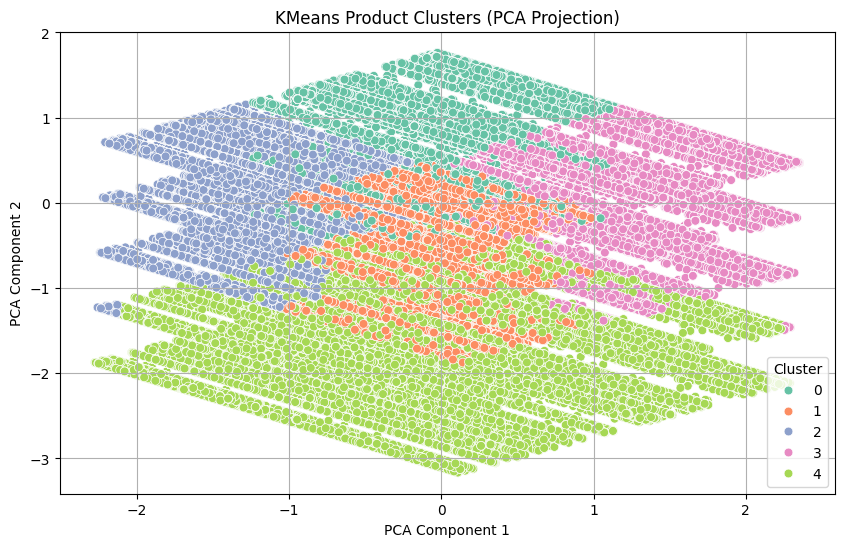

In [14]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

plt.figure(figsize=(10,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=product_df['cluster'], palette='Set2', s=40)
plt.title('KMeans Product Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()